In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [3]:
with open('../data/molecules_enh.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [4]:
structures = pd.read_feather('../data/structures_enh.feather')
molecules_df = pd.read_feather('../data/molecules.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



In [5]:
dipole_moments = pd.read_feather('../data/dipole_moments.feather')
magnetic_shielding_tensors = pd.read_feather('../data/magnetic_shielding_tensors.feather')
mulliken_charges = pd.read_feather('../data/mulliken_charges.feather')
potential_energy = pd.read_feather('../data/potential_energy.feather')
scalar_coupling_contributions = pd.read_feather('../data/scalar_coupling_contributions.feather')

In [6]:
labelled_enh = labelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#labelled_enh.head(32)

In [7]:
unlabelled_enh = unlabelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#unlabelled_enh.head(32)

In [ ]:
len(labelled), len(labelled_enh)

In [ ]:
nn_args = dict(dipole_moments=dipole_moments,
               magnetic_shielding_tensors=magnetic_shielding_tensors,
               mulliken_charges=mulliken_charges,
               potential_energy=potential_energy,
               scalar_coupling_contributions=scalar_coupling_contributions)

In [ ]:
model.structures.dtypes

In [ ]:
labelled_enh.dtypes

In [ ]:
from models import NNModel, partition_data

print('Running')

#data_df = labelled[labelled.type == '1JHC'].head(10)
data_df = labelled_enh.head(10)
train_df, test_df = partition_data(data_df, train_frac=1)
train_df = train_df.copy()
        
model = NNModel(model_args = dict(molecules=molecules,
                                  structures=structures),
               **nn_args)
#model.corr(train_df, train_df)
model.setup_data(train_df, train_df)

In [ ]:
list(model.input_df.columns)

In [ ]:
model.input_df.dtypes

In [ ]:
labelled_enh.head()

In [ ]:
import itertools

In [ ]:
df = labelled_enh.head(32)

In [ ]:
#df[['molecule_name']].merge(dipole_moments, left_on='molecule_name', right_on='molecule_name')


In [14]:
def plot_history(history, label):
    n = 5
    
    loss = np.array(history.history['scc_loss'], dtype='float32')
    val_loss = np.array(history.history['val_scc_loss'], dtype='float32')
    
    loss_mean = loss.mean()
    loss_nstd = n * loss.std()
    
    val_loss_mean = val_loss.mean()
    val_loss_nstd = n * val_loss.std()
       
#     mn = min(loss_mean - loss_nstd, val_loss_mean - val_loss_nstd)
#     mx = min(loss_mean + loss_nstd, val_loss_mean + val_loss_nstd)
    mn = loss_mean - loss_nstd
    mx = loss_mean + loss_nstd
    
#     print(loss.min(), loss.max())
#     print(val_loss.min(), val_loss.max())
#     print(loss_mean, loss_nstd, val_loss_mean, val_loss_nstd)
#     print(mn, mx)
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(mn, mx)
    _= plt.legend(['Train','Validation'], loc='upper left')

In [15]:
nn_args = dict(dipole_moments=dipole_moments,
               magnetic_shielding_tensors=magnetic_shielding_tensors,
               mulliken_charges=mulliken_charges,
               potential_energy=potential_energy,
               scalar_coupling_contributions=scalar_coupling_contributions,
               epochs=100,
               learning_rate=0.001,
               validation_split=0.3
               )

Training 21000 samples for 1JHC
Train on 14699 samples, validate on 6301 samples
Epoch 1/100
14699/14699 [==============================] - 15s 998us/sample - loss: 6.8159 - scc_loss: 1.1812 - output_dipole_moments_loss: 1.1534 - output_magnetic_shielding_tensors_loss: 1.1284 - output_mulliken_charges_loss: 1.0862 - output_potential_energy_loss: 1.1971 - output_scalar_coupling_contributions_loss: 1.0579 - val_loss: 9.8392 - val_scc_loss: 1.5636 - val_output_dipole_moments_loss: 1.4642 - val_output_magnetic_shielding_tensors_loss: 1.7733 - val_output_mulliken_charges_loss: 1.3197 - val_output_potential_energy_loss: 1.1954 - val_output_scalar_coupling_contributions_loss: 2.4563
Epoch 2/100
14699/14699 [==============================] - 3s 181us/sample - loss: 4.8171 - scc_loss: 0.7161 - output_dipole_moments_loss: 0.9015 - output_magnetic_shielding_tensors_loss: 0.8334 - output_mulliken_charges_loss: 0.8081 - output_potential_energy_loss: 0.9010 - output_scalar_coupling_contributions_los

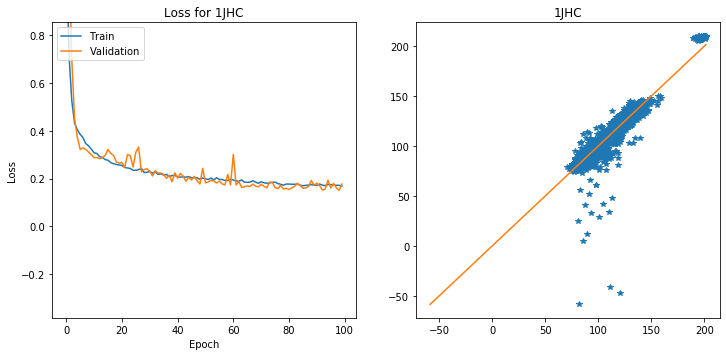

In [28]:
### from models import NNModel
from models import partition_data, NNModel

# import tensorflow as tf
# from tensorflow.keras import backend as tfbe

# tf.reset_default_graph()

# atom_count_ranges = [(1, 10), (11, 15), (16, 20), (21, 25), (26, 30)]
# C_count_ranges = [(1, 5), (6, 6), (7, 7), (8, 9)]
coupling_types = sorted(labelled_enh.type.unique())[0:1]
def test(data, count=5000):
    global model
    global history
    
    plt.figure(figsize=(25, 25))
    
    for i, t in enumerate(coupling_types, 1):    
        data_df = data[data.type == t].head(count)

        train_df, test_df = partition_data(data_df)

        if len(train_df) < 10 or len(test_df) < 10:
            continue

        print(f'Training {len(train_df)} samples for {t}')

        model = NNModel(dict(molecules=molecules, 
                             structures=structures),
                        **nn_args)
        history = model.fit(train_df, train_df)
        
        print(f'Evaluating {len(test_df)} samples')
        output, score = model.evaluate(test_df, test_df)
        print(f'{t} score: {score} (trained on {len(train_df)} elements)')


        plt.subplot(4, 4, 2 * i - 1)
        plot_history(history, t)
        
        #print(output.shape, test_df.values.shape)
        #pprint(list(zip(output[0:20, 0], test_df.scalar_coupling_constant[0:20])))

        plt.subplot(4, 4, 2 * i)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        mn = min(test_df.scalar_coupling_constant.min(), output.min())
        mx = min(test_df.scalar_coupling_constant.max(), output.max())

        plt.plot([mn, mx], [mn, mx])
        plt.title(t)
                        
    plt.show()
        
test(labelled_enh, 30000)


In [ ]:
w, b = model.model.layers[1].get_weights()

In [ ]:
w2 = w.sum(axis=1)

In [ ]:
w2.min(), w2.max(), w2.mean()

In [ ]:
model.numeric_input_df.columns[np.abs(w.sum(axis=1)) > 10]

In [ ]:
from models import partition_data, NNModel

def train(data):
    models = {}
    for t in sorted(data.type.unique()):
        train_df = data[data.type == t]
        print(f'Training {len(train_df)} samples for {t}')
        model = NNModel(dict(molecules=molecules, 
                             structures=structures),
                        None)
        models[t] = model
        model.fit(train_df, train_df)
    
    return models

models = train(labelled_enh)

In [ ]:
unlabelled_enh.shape

In [ ]:
def predict(data, models):
    out_df = None
    
    for t in sorted(data.type.unique()):
        predict_df = data[data.type == t]
        print(f'Predicting {len(predict_df)} samples for {t}')
        output = models[t].predict(predict_df)
        
        id = predict_df['id']
        out_df_coupling = pd.DataFrame(data={'id':id, 'scalar_coupling_constant':output.flatten()}, index=predict_df.index)
        
        if out_df is None:
            out_df = out_df_coupling
        else:
            out_df = out_df.append(out_df_coupling).sort_index()

    return out_df.sort_index()
    
#%prun -s cumulative f(unlabelled.head(10000))
prediction = predict(unlabelled_enh, models)

In [ ]:
prediction.head()

In [ ]:
prediction.to_csv('../data/pred.csv',index=False)

In [ ]:
import pickle
with open('nn.pickle', 'wb') as f:
    pickle.dump(models, f)

In [ ]:
models